In [1]:
import os
import math
import random
from ast import literal_eval
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import torch.nn.functional as F

from IPython.display import Audio
import torchaudio
import torchaudio.functional as audioF
import torchaudio.transforms as audioT
from torchaudio.utils import download_asset
import librosa

from utils.plot_torchaudio import plot_specgram, plot_spectrogram, plot_waveform
from utils.preprocess_torchaudio import waveform_to_mel_spectrogram_db, truncate_voice, apply_random_codec, apply_noise, apply_reverb, spectrogram_to_tensor_save

# Set the device to gpu if possible else to cpu
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(DEVICE)
if torch.cuda.is_available():
    print('GPU : ', torch.cuda.get_device_name())

GPU :  NVIDIA GeForce GTX 1660 Ti


In [4]:
# path_quatre = '../../data/clips_wav/common_voice_fr_21895013.wav'
# path_trois = '../../data/clips_wav/common_voice_fr_23922749.wav'
# path_deux = '../../data/clips_wav/common_voice_fr_23916432.wav'
# path_un = '../../data/clips_wav/common_voice_fr_21895015.wav'
# path_oui = '../../data/clips_wav/common_voice_fr_23927536.wav'
# path_non = '../../data/clips_wav/common_voice_fr_23908898.wav'

path_quatre = '../../data/clips_wav/common_voice_fr_21940924.wav'
path_trois = '../../data/clips_wav/common_voice_fr_21940527.wav'
path_deux = '../../data/clips_wav/common_voice_fr_21895036.wav'
path_un = '../../data/clips_wav/common_voice_fr_21947279.wav'
path_oui = '../../data/clips_wav/common_voice_fr_21895847.wav'
path_non = '../../data/clips_wav/common_voice_fr_21895035.wav'

path_quatre = '../../data/clips_wav/common_voice_fr_22205606.wav'

Ajustement des dimensions directement sur les waveforms

Troncage si trop grand, en se basant sur 2 sec d'enregistrement. Si enregistrement encore plus petit padding par 0 sur le waveform

torch.Size([1, 517248])


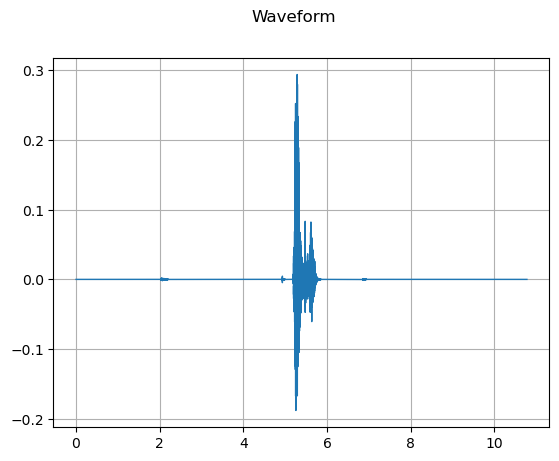

In [5]:
waveform, sr = torchaudio.load(path_quatre)
print(waveform.shape)
plot_waveform(waveform, sr)
Audio(waveform, rate=sr)


torch.Size([1, 96000])


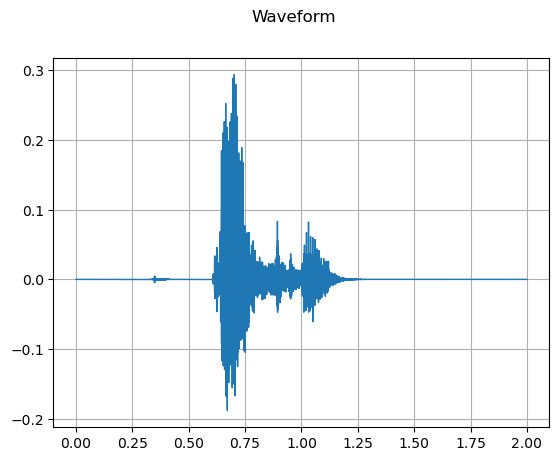

In [6]:
# sample rate 48000 => 1sec donc on veut un découpage de 96000 sample

print(waveform[:,220000:316000].shape)
plot_waveform(waveform[:,220000:316000], sr)
Audio(waveform[:,220000:316000], rate=sr)

Découpage en fonction d'un seuil (moyenne du signal ou médianne)

torch.Size([1, 517248])


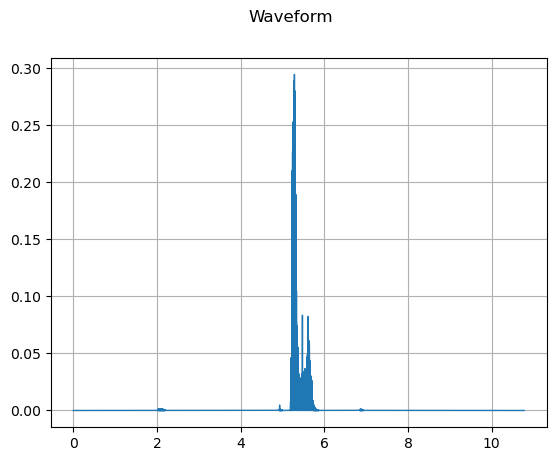

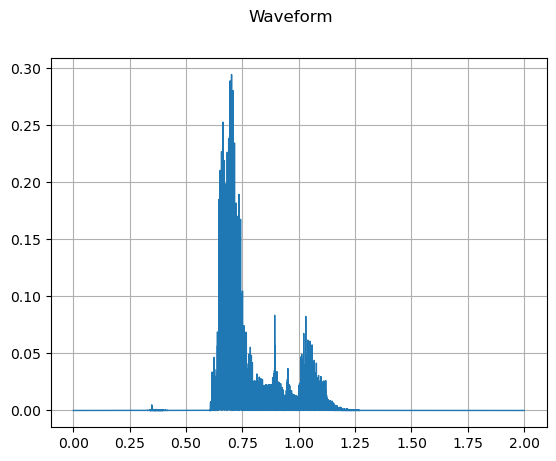

In [7]:
absolute_waveform = torch.abs(waveform)
print(absolute_waveform.shape)
plot_waveform(absolute_waveform, sr)
plot_waveform(absolute_waveform[:,220000:316000], sr)

In [8]:
signal_mean = torch.mean(absolute_waveform)
signal_median = torch.median(absolute_waveform)
signal_max = torch.max(absolute_waveform)
signal_min = torch.min(absolute_waveform)

print('mean : ', signal_mean)
print('median : ', signal_median)
print('max : ', signal_max)
print('min : ', signal_min)



mean :  tensor(0.0009)
median :  tensor(0.)
max :  tensor(0.2942)
min :  tensor(0.)


Sur un enregistrement très long ou très court, les valeurs des moyennes et médianne ne permettront pas de trouver un seuil. Car elles vont beaucoup trop varier.

Le mieux serait de rechercher la portion de taille 96000 avec la moyenne la plus élevé, ce qui correspondrait à la portion contenant la majorité de la voix.

torch.Size([1, 96000])


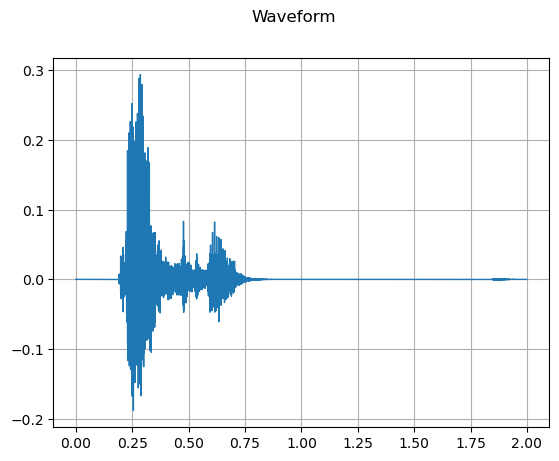

In [9]:
truncated_waveform = truncate_voice(waveform, target_sample_number=96000)
print(truncated_waveform.shape)
plot_waveform(truncated_waveform, sr)

torch.Size([1, 48000])


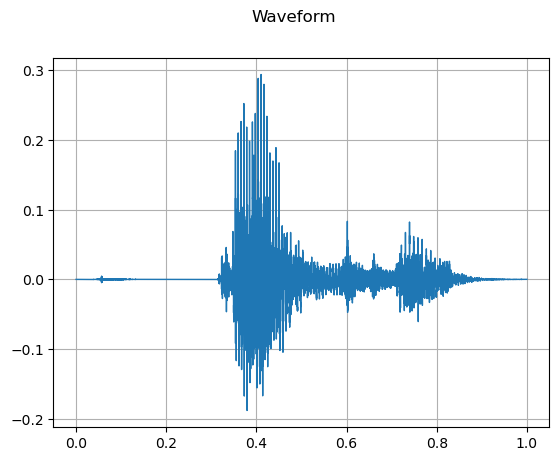

In [10]:
truncated_waveform_small = truncate_voice(waveform, target_sample_number=48000)
print(truncated_waveform_small.shape)
plot_waveform(truncated_waveform_small, sr)

Dimension du mel Spectrogram

torch.Size([15, 188])


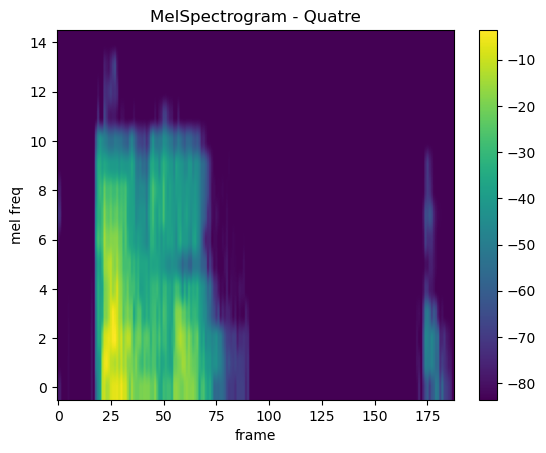

In [11]:
mel_spec = waveform_to_mel_spectrogram_db(truncated_waveform, sample_rate=sr)
print(mel_spec.shape)
plot_spectrogram(
    mel_spec, title="MelSpectrogram - Quatre", ylabel='mel freq')

Test autre audio

torch.Size([1, 67968])
torch.Size([1, 96000])
torch.Size([15, 188])


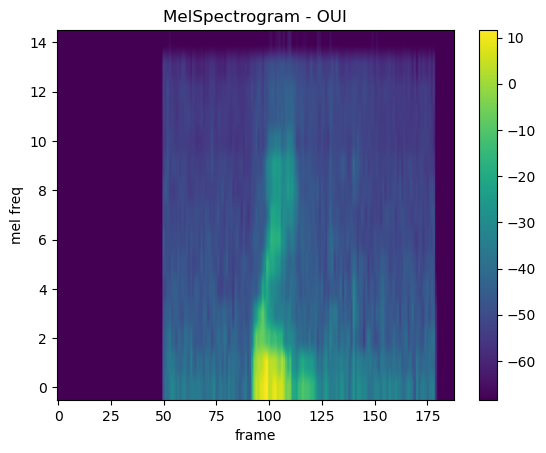

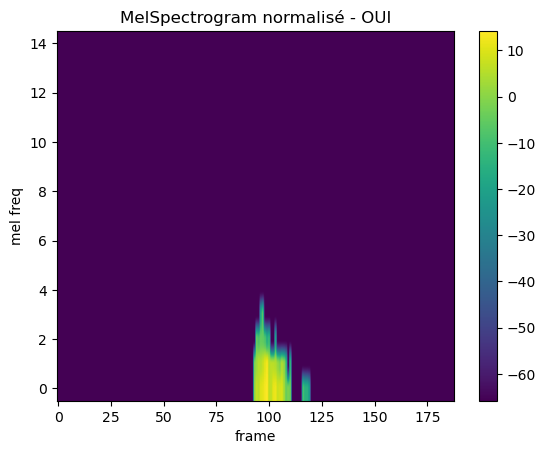

In [12]:
oui, sr = torchaudio.load(path_oui)
print(oui.shape)
oui = truncate_voice(oui, target_sample_number=96000)
print(oui.shape)
mel_spec_oui = waveform_to_mel_spectrogram_db(oui, sample_rate=sr)
print(mel_spec_oui.shape)
plot_spectrogram(
    mel_spec_oui, title="MelSpectrogram - OUI", ylabel='mel freq')


mean, std = torch.mean(mel_spec_oui), torch.std(mel_spec_oui)
normalized_oui = (mel_spec_oui-mean)/std
plot_spectrogram(
    normalized_oui, title="MelSpectrogram normalisé - OUI", ylabel='mel freq')

Audio(oui, rate=sr)

torch.Size([1, 77184])
torch.Size([1, 96000])
torch.Size([128, 94])


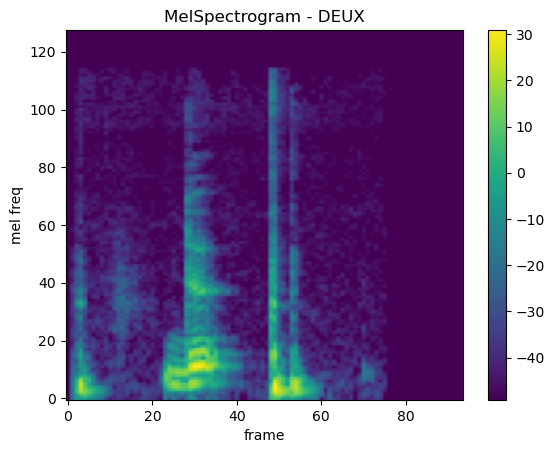

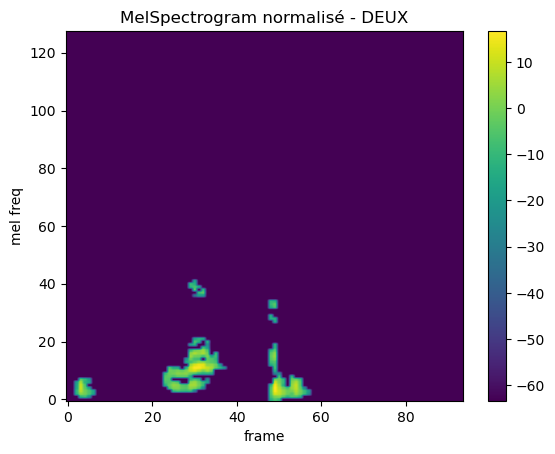

In [6]:
deux, sr = torchaudio.load(path_deux)
print(deux.shape)
deux = truncate_voice(deux, target_sample_number=96000)
print(deux.shape)
mel_spec_deux = waveform_to_mel_spectrogram_db(deux, sample_rate=sr, n_mels=128, n_fft=2048, hop_length=1024, win_length=2048)
print(mel_spec_deux.shape)
plot_spectrogram(
    mel_spec_deux, title="MelSpectrogram - DEUX", ylabel='mel freq')


mean, std = torch.mean(mel_spec_deux), torch.std(mel_spec_deux)
normalized_deux = (mel_spec_deux-mean)/std
plot_spectrogram(
    normalized_deux, title="MelSpectrogram normalisé - DEUX", ylabel='mel freq')

Audio(deux, rate=sr)

Augmentation du jeu de donnée après découpage

In [2]:
speech_sample_rate=48000
tensor_filename = 'mel_spec_wav_6'

# création target tensor
df = pd.read_csv('../../data/data.csv', delimiter=',')
sentence = {'oui': 0, 'non': 1, 'un': 2, 'deux': 3, 'trois': 4, 'quatre': 5}
df['sentence'] = df['sentence'].map(sentence)
df = pd.get_dummies(df, columns=['sentence'], dtype=float)
target = np.array(df[['sentence_0', 'sentence_1', 'sentence_2', 'sentence_3', 'sentence_4', 'sentence_5']])

# création waveforms
df['path_wav'] = df['path'].apply(lambda x: '../../data/clips_wav/' + x)
waveforms = df['path_wav'].apply(lambda x: torchaudio.load(x)[0])
print('nombre signaux : ', len(waveforms))

# découpage des waveforms (homogénéisation des dimensions)
waveforms = [truncate_voice(waveform, target_sample_number=48000) for waveform in waveforms]

initial_waveforms_num = len(waveforms)
for i in range(1,initial_waveforms_num):  
    waveform = waveforms[i]
    augmented_waveforms = []
    
    augment_num = random.randint(0, 2)
    
    if augment_num == 0:
        augmented_waveforms.append(apply_reverb(waveform))
        target = np.append(target, [target[i]], axis=0)   
        augment_num = random.randint(1, 2)
        if augment_num == 1:
            augmented_waveforms.append(apply_noise(waveform))
        elif augment_num == 2:
            augmented_waveforms.append(apply_random_codec(waveform, speech_sample_rate))
    elif augment_num == 1:
        augmented_waveforms.append(apply_noise(waveform))
    elif augment_num == 2:
        augmented_waveforms.append(apply_random_codec(waveform, speech_sample_rate))
    
    # waveforms = pd.concat([waveforms, pd.Series(augmented_waveforms)], ignore_index=True)
    waveforms = waveforms + augmented_waveforms
    target = np.append(target, [target[i]], axis=0)    

del augmented_waveforms
print('waveforms shape après augment : ', len(waveforms))

# conversion en melspectrogramme
mel_spectrograms_wav = [waveform_to_mel_spectrogram_db(waveform, n_mels=128, n_fft=512, hop_length=512) for waveform in waveforms]
del waveforms
print('mel specs shape :', len(mel_spectrograms_wav))

target = torch.tensor(target, dtype=torch.float32)
torch.save(target, f'../../data/target_{tensor_filename}.pt')
del target

spectrogram_to_tensor_save(mel_spectrograms_wav, tensor_filename)
del mel_spectrograms_wav

nombre signaux :  8652
waveforms shape après augment :  20138


c:\Users\ramad\anaconda3\envs\.venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


mel specs shape : 20138


d:\Mes Documents\Cours\DE3\BigDataProject\voice-quiz\model\notebooks\utils\preprocess_torchaudio.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectrograms = [torch.tensor(data, dtype=torch.float32) for data in spectrograms]
